In [1]:
from IPython.core.interactiveshell import InteractiveShell
from datetime import datetime
import time

#basic externals
import pandas as pd
import numpy as np
import os
import matplotlib as plt 

%matplotlib inline
%reload_ext autoreload
%autoreload 2

from sklearn import linear_model
from sklearn import metrics
from xm_functions import *

from sklearn.model_selection import TimeSeriesSplit

InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 20
pd.options.display.max_columns = 50 
pd.set_option(
    "display.float_format", lambda x: "%.3f" % x
    )  # display numbers as decimals instead of scientific value

plt.rcParams["font.size"] = (18)

## Feather

In [2]:
import feather
df_train = feather.read_dataframe('df_train').drop('index', axis = 1)
df_test = feather.read_dataframe('df_test').drop('index', axis = 1)

C:\Users\Maly-Fenix\Anaconda3\lib\site-packages\pyarrow\pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [3]:
prophet_predictions = feather.read_dataframe('prophet_predictions').drop('index', axis = 1)
prophet_predictions['Date'] = prophet_predictions['ds']

In [4]:
df_train = df_train.query('Open==1 & Sales >0').reset_index(drop=True)

In [17]:
formated_df=df_train.merge(prophet_predictions, on=['Date', 'Store'],suffixes=('','_bis') )

In [18]:

formated_df.columns
formated_df.sample(3)

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Open', 'Promo', 'StateHoliday',
       'SchoolHoliday', 'Year', 'Month', 'Day', 'Timestamp', 'StoreType',
       'Assortment', 'CompetitionDistance', 'Promo2', 'CompetitionDaysOpen',
       'CompetitionIsOpen', 'Promo2Days', 'AfterSchoolHoliday',
       'BeforeSchoolHoliday', 'AfterIsStateHoliday', 'BeforeIsStateHoliday',
       'AfterPromo', 'BeforePromo', 'rolling_sales_half_year_med',
       'rolling_sales_prev_year_med', 'rolling_sales_prev_year2_med',
       'rolling_sales_past_quarter_med', 'StoreType_a', 'StoreType_b',
       'StoreType_c', 'StoreType_d', 'StateHoliday_a', 'StateHoliday_b',
       'StateHoliday_c', 'StateHoliday_no', 'Assortment_a', 'Assortment_b',
       'Assortment_c', 'ds', 'yhat', 'yhat_lower', 'yhat_upper', 'y'],
      dtype='object')

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,Timestamp,StoreType,Assortment,CompetitionDistance,Promo2,CompetitionDaysOpen,CompetitionIsOpen,Promo2Days,AfterSchoolHoliday,BeforeSchoolHoliday,AfterIsStateHoliday,BeforeIsStateHoliday,AfterPromo,BeforePromo,rolling_sales_half_year_med,rolling_sales_prev_year_med,rolling_sales_prev_year2_med,rolling_sales_past_quarter_med,StoreType_a,StoreType_b,StoreType_c,StoreType_d,StateHoliday_a,StateHoliday_b,StateHoliday_c,StateHoliday_no,Assortment_a,Assortment_b,Assortment_c,ds,yhat,yhat_lower,yhat_upper,y
842762,652,4,2015-07-30,8503.000,1.000,1,no,1,2015,7,30,0.950,a,a,20390.000,0,0,0,0,0,0,66,0,0,0,5506.000,0.000,5500.000,5597.000,1,0,0,0,0,0,0,1,1,0,0,2015-07-30,7138.621,4834.450,9367.805,8503.000
421015,847,6,2014-03-29,6565.000,1.000,0,no,0,2014,3,29,0.457,c,c,190.000,1,0,0,236,81,-16,87,-20,8,-2,0.000,8073.000,8771.500,0.000,0,0,1,0,0,0,0,1,0,0,1,2014-03-29,8196.335,6405.386,9950.648,6565.000
275104,166,4,2013-10-24,5975.000,1.000,1,no,1,2013,10,24,0.299,a,c,100.000,1,0,0,80,0,0,21,-8,0,0,5136.500,nan,nan,5701.500,1,0,0,0,0,0,0,1,0,0,1,2013-10-24,5064.568,3435.502,6755.517,5975.000


In [19]:
formated_df = formated_df.sort_values(['Date', 'Store'])

In [20]:

keep_cols = ['Sales', 'Promo', 'Timestamp',
       'SchoolHoliday', 'Promo2', 'CompetitionDistance', 'CompetitionDaysOpen',
       'Promo2Days', 'AfterSchoolHoliday',
       'BeforeSchoolHoliday', 'AfterIsStateHoliday', 'BeforeIsStateHoliday',
       'AfterPromo', 'BeforePromo', 
       'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d',
       'Assortment_a', 'Assortment_b', 'Assortment_c',  'yhat',
       #'StateHoliday_a', 'StateHoliday_b', 'StateHoliday_c', 'StateHoliday_no',
       'yhat_lower', 'yhat_upper', 'Date'
            ]
formated_df = formated_df[keep_cols]


In [21]:
max_date=formated_df['Date'].max()
from datetime import datetime, timedelta
train_size=48
test_date = max_date-timedelta(days=train_size)
nb_rows= len(formated_df); 
print(nb_rows,'rows before split')

data_train = formated_df.query('Date < @test_date')
data_test = formated_df.query('Date >= @test_date')

y= formated_df['Sales']
X= formated_df.drop(['Sales', 'Date'], axis=1)

y_train= data_train['Sales']
y_test=data_test['Sales']
y_true = y_test

X_train=data_train.drop(['Sales', 'Date'], axis=1)
X_test=data_test.drop(['Sales', 'Date'], axis=1)


print(X_train.shape[0],'rows in training set')
print(X_test.shape[0],'rows in test set')

844338 rows before split
797340 rows in training set
46998 rows in test set


In [22]:

def rmspe_calc(y, yhat):
    return np.sqrt(np.mean((yhat/y-1) ** 2))

def rmspe_xg(yhat, y):
    y = np.expm1(y.get_label())
    yhat = np.expm1(yhat)
    return "rmspe", rmspe(y,yhat)

## XGBoost

In [23]:
def save_scores(df_scores, y_pred, y_true, nb_rounds, params):
    r2_score = metrics.r2_score(y_true, y_pred)
    mean_abs_err = metrics.mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
    rmspe = rmspe_calc(y_true, y_pred)
    
    learning_rate = params['learning_rate']
    max_depth= params['max_depth']
    colsample_bytree = params['colsample_bytree']
   # n_estimators = params['n_estimators']
    subsample = params['subsample']
    
    current_scores = pd.DataFrame([[nb_rounds, r2_score, mean_abs_err, rmse, rmspe, learning_rate, max_depth, colsample_bytree, subsample]]
                , columns=['nb_rounds', 'r2_score', 'mean_abs_err', 'rmse', 'rmspe', 'learning_rate', 'max_depth', 'colsample_bytree', 'subsample'])
    df_scores = df_scores.append(current_scores)
    return df_scores
    

In [24]:
def run_xgb(params, dtrain, dtest, y_true, current_rounds = 0):
    num_boost_round = 5
    if current_rounds>0:
        xg_reg = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,feval=rmspe_xg, xgb_model='xgbmodel')
    else:
        xg_reg = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round )

    df_scores = pd.DataFrame()

    y_pred = xg_reg.predict(dtest)
    df_scores = save_scores(df_scores, y_pred, y_true, current_rounds+num_boost_round , params)

    xg_reg.save_model("xgbmodel")

    for i in range(10):
        xg_reg = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round ,feval=rmspe_xg, xgb_model='xgbmodel')
        xg_reg.save_model("xgbmodel")
        y_pred = xg_reg.predict(dtest)
        df_scores = save_scores(df_scores, y_pred, y_true, current_rounds+num_boost_round*(i+2), params)

    return df_scores, y_pred

In [25]:
tscv = TimeSeriesSplit(5)
tscv.split(X)

<generator object TimeSeriesSplit.split at 0x000001FE8BA90CF0>

In [26]:
import xgboost as xgb

params = {"objective": "reg:linear",
          "booster" : "gbtree",
          "learning_rate": 0.06,
          "max_depth": 10,
          "min_child_weight":2,
          "subsample": 0.8,
          "colsample_bytree": 0.7,
          "silent": 1,
          "seed": 10,
          }

#watchlist = [(dtrain, 'train_rmspe'), (dtest, 'eval_rmspe')]
progress = dict()
df_scores = pd.DataFrame()
y_preds= pd.DataFrame()
y_true = y_test

split_i=0
current_rounds = 0

dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

#df_split_scores, y_pred_split =  run_xgb( params, dtrain, dtest,y_test, current_rounds)
#df_scores = df_scores.append(df_split_scores)
#y_preds[str(split_i)] = y_pred_split

hyper_param = 'learning_rate'
for i in [0.06]:
    params[hyper_param] = round(i, 3)
    print(hyper_param,':', params[hyper_param])
    
    df_split_scores, y_pred_split =  run_xgb( params, dtrain, dtest,y_test, current_rounds)
    df_scores = df_scores.append(df_split_scores)
    y_preds[str(split_i)] = y_pred_split


C:\Users\Maly-Fenix\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Maly-Fenix\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


learning_rate : 0.06


In [27]:
xg_reg = xgb.train(params=params, dtrain=dtrain, num_boost_round=1 ,feval=rmspe_xg, xgb_model='xgbmodel')
y_pred = xg_reg.predict(dtest)

In [28]:
y_preds.mean(axis=1).values

array([ 4667.7397,  2765.0469,  4401.8916, ...,  8113.309 , 24961.46  ,
        9296.891 ], dtype=float32)

In [29]:
y_preds['pred_mean']= y_preds.iloc[:, :5].mean(axis=1).values
#taking latest index for tests    
y_pred = y_preds['pred_mean'].values

In [30]:

from sklearn import metrics 

r2_score    = metrics.r2_score(y_true, y_pred)
mean_abs_err= metrics.mean_absolute_error(y_true, y_pred)
rmse        = np.sqrt(metrics.mean_squared_error(y_true, y_pred))
rmspe       = rmspe_calc(y_true, y_pred)

r2_score    = round(r2_score    ,4) 
mean_abs_err= round(mean_abs_err,4) 
rmse        = round(rmse        ,4) 
rmspe       = round(rmspe       ,4) 

print('R2_score     ',r2_score)
#print('mean_abs_err ',mean_abs_err)
print('RMSE         ',rmse)
print('RMSPE        ',rmspe)

R2_score      0.8685
RMSE          1120.5375
RMSPE         0.1414


'2.2.2'

C:\Users\Maly-Fenix\Anaconda3\lib\site-packages\altair\utils\core.py:284: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


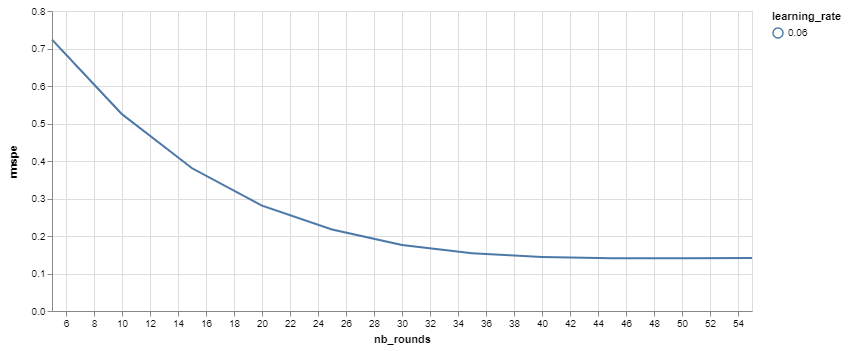

In [31]:
import altair as alt
alt.__version__
df_plt = df_scores
scoring_method='rmspe'
alt.Chart(df_plt, width = 700 ).mark_line().encode(
    x='nb_rounds',
    y=scoring_method,
    color = hyper_param+':N'
)

In [32]:
if False :
    xgb.plot_tree(xg_reg,num_trees=0)
    fig_size(10,4)
    plt.show()

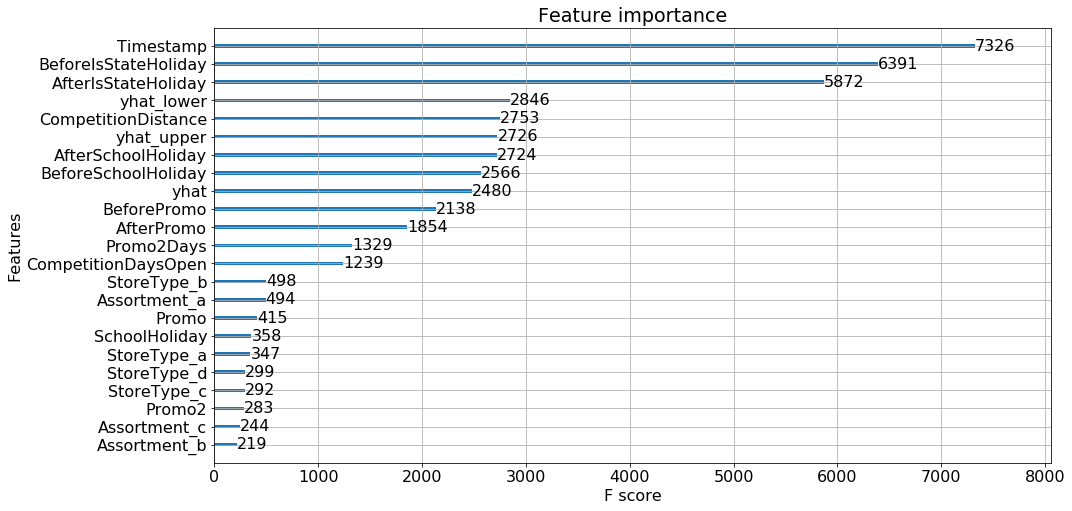

In [33]:

fig_size(15,8, 16)
xgb.plot_importance(xg_reg)
plt.show()


## See results

In [34]:
results = df_train.merge(prophet_predictions, on=['Date', 'Store'],suffixes=('','_bis') ).loc[X_test.index]
results['y_pred'] = y_pred
results['y_true'] = results['Sales']
results.head(5)

,Store,DayOfWeek,Date,Sales,Open,Promo,StateHoliday,SchoolHoliday,Year,Month,Day,Timestamp,StoreType,Assortment,CompetitionDistance,Promo2,CompetitionDaysOpen,CompetitionIsOpen,Promo2Days,AfterSchoolHoliday,BeforeSchoolHoliday,AfterIsStateHoliday,BeforeIsStateHoliday,AfterPromo,BeforePromo,rolling_sales_half_year_med,rolling_sales_prev_year_med,rolling_sales_prev_year2_med,rolling_sales_past_quarter_med,StoreType_a,StoreType_b,StoreType_c,StoreType_d,StateHoliday_a,StateHoliday_b,StateHoliday_c,StateHoliday_no,Assortment_a,Assortment_b,Assortment_c,ds,yhat,yhat_lower,yhat_upper,y,y_pred,y_true
797340,1,6,2015-06-13,4256.000,1.000,0,no,0,2015,6,13,0.903,c,a,1270.000,0,2476,1,0,64,-44,9,0,8,-2,5160.500,7826.500,0.000,5419.000,0,0,1,0,0,0,0,1,1,0,0,2015-06-13,4767.235,3714.897,5855.742,4256.000,4667.740,4256.000
797341,2,6,2015-06-13,2574.000,1.000,0,no,0,2015,6,13,0.903,a,a,570.000,1,2781,1,1902,29,-30,19,0,8,-2,5149.000,7826.500,0.000,4920.500,1,0,0,0,0,0,0,1,1,0,0,2015-06-13,2893.842,1470.453,4190.908,2574.000,2765.047,2574.000
797342,3,6,2015-06-13,4687.000,1.000,0,no,0,2015,6,13,0.903,a,a,14130.000,1,3116,1,1531,18,-16,9,0,8,-2,5147.000,8714.000,0.000,4920.500,1,0,0,0,0,0,0,1,1,0,0,2015-06-13,4743.963,2405.431,6806.959,4687.000,4401.892,4687.000
797343,4,6,2015-06-13,9779.000,1.000,0,no,0,2015,6,13,0.903,c,c,620.000,0,2111,1,0,18,-33,19,0,8,-2,5143.000,9657.000,0.000,4522.500,0,0,1,0,0,0,0,1,0,0,1,2015-06-13,10709.848,8609.411,12817.738,9779.000,9590.711,9779.000
797344,5,6,2015-06-13,2156.000,1.000,0,no,0,2015,6,13,0.903,a,a,29910.000,0,73,1,0,29,-30,9,0,8,-2,5130.500,8714.000,0.000,4522.500,1,0,0,0,0,0,0,1,1,0,0,2015-06-13,2180.036,744.778,3690.629,2156.000,2185.706,2156.000


In [35]:
import matplotlib.pyplot as plt  
def compare_result_plot(results, col_name, y_col='Sales'):
    plt.rcParams["figure.figsize"] = (10,4)
    X= results[col_name]
    if X.dtype=='object':
        x_range = X.unique()
    else:
        x_range = np.linspace(X.min(), X.max(), X.nunique())
     
    y_true= results[['y_true', col_name]].groupby(col_name).mean().values
    y_pred= results[['y_pred', col_name]].groupby(col_name).mean().values

    X = X.values
    plt.plot(x_range, y_true, color='cornflowerblue', linewidth=3, alpha=0.5,
        label="true mean")
    plt.plot(x_range, y_pred, color='red', linewidth=3, linestyle = '-', alpha=0.5,
         label="pred mean")

    silent = plt.legend(loc='lower right')
    silent = plt.title('Sales mean per '+col_name)
    silent = plt.ylabel('sales mean')
    silent = plt.xlabel(col_name)
        
    plt.show()

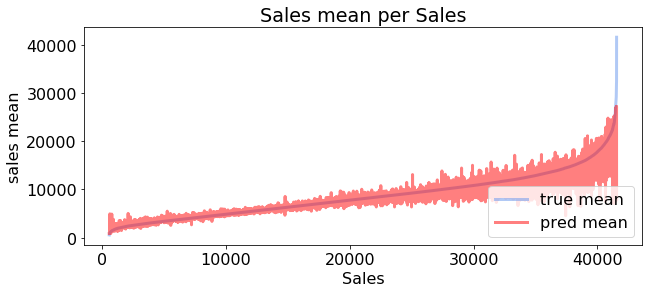

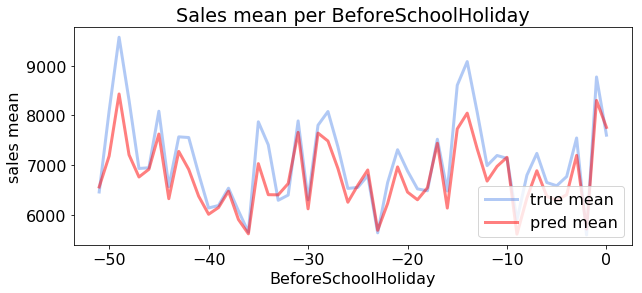

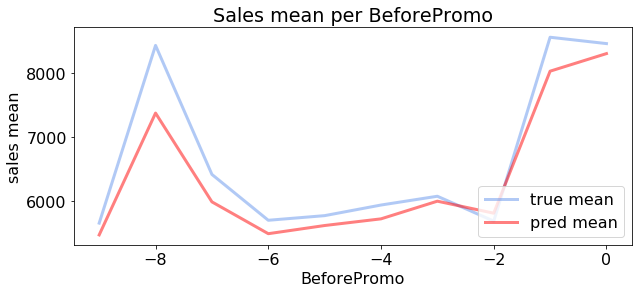

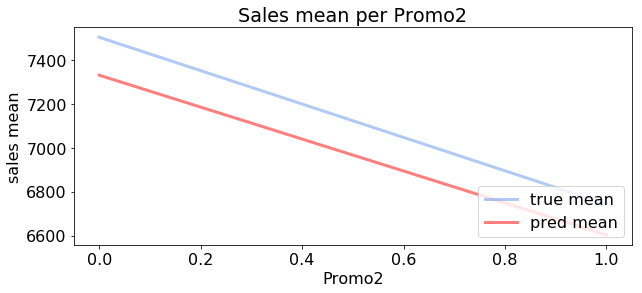

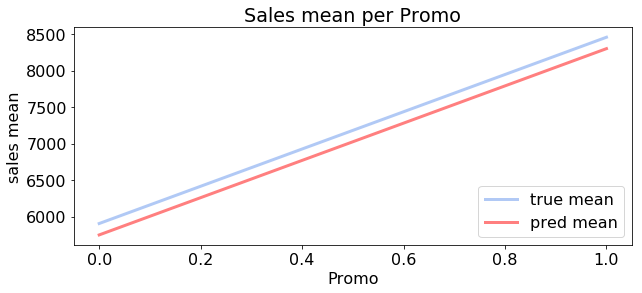

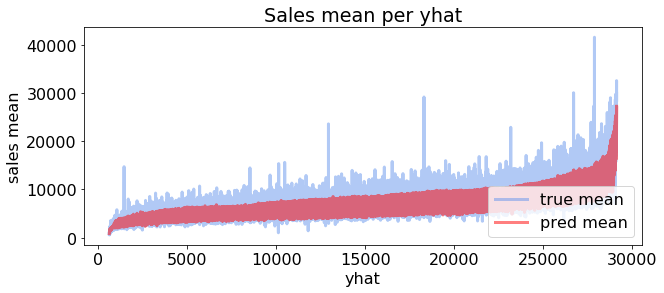

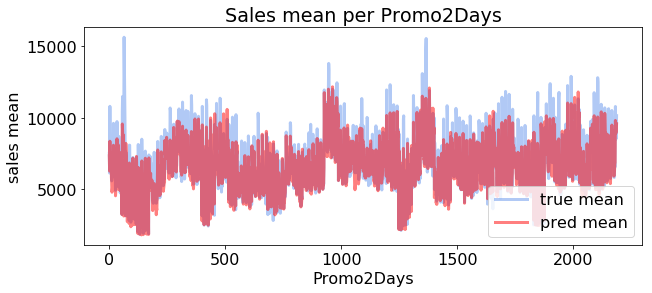

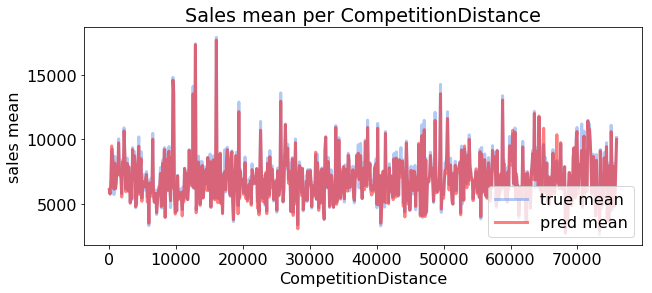

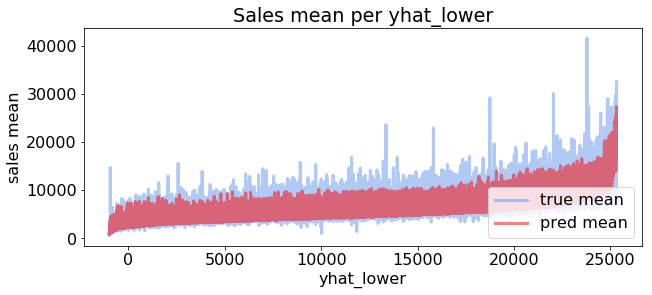

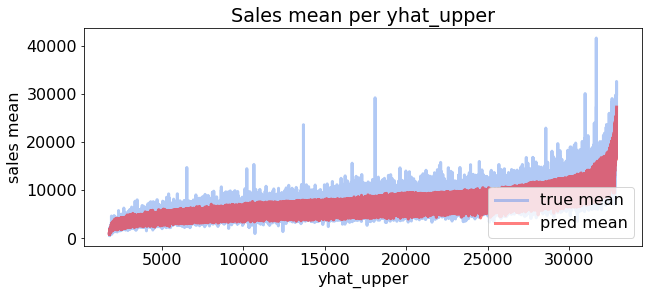

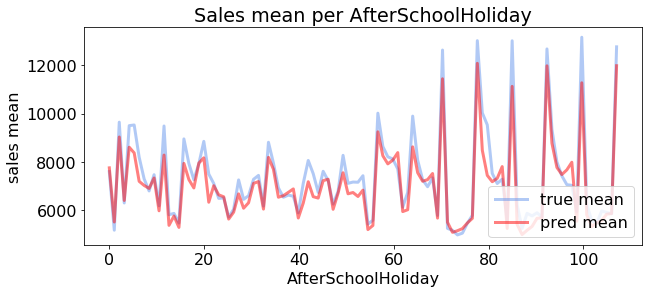

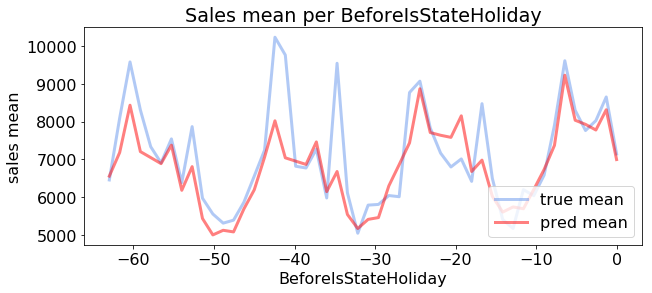

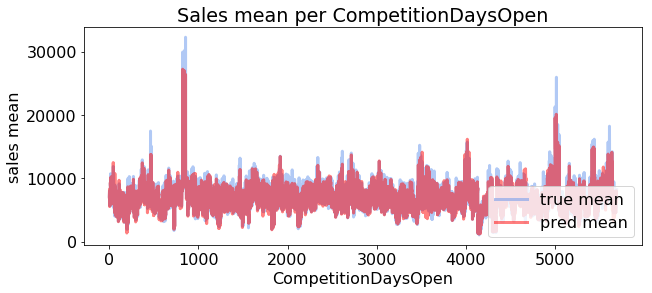

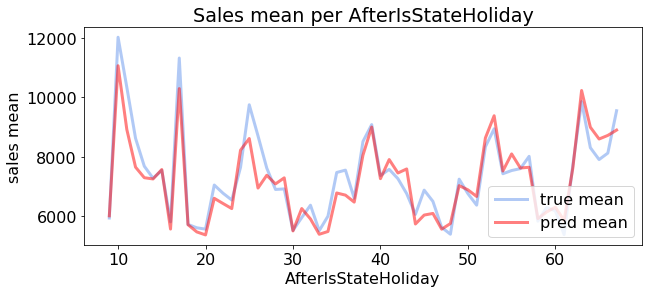

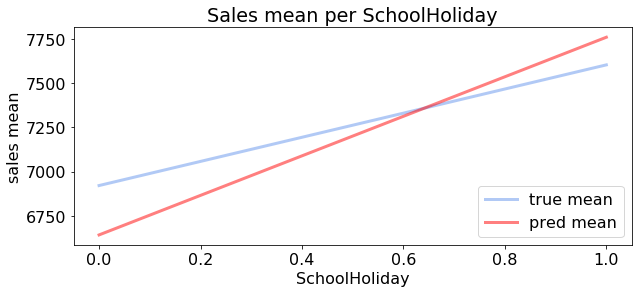

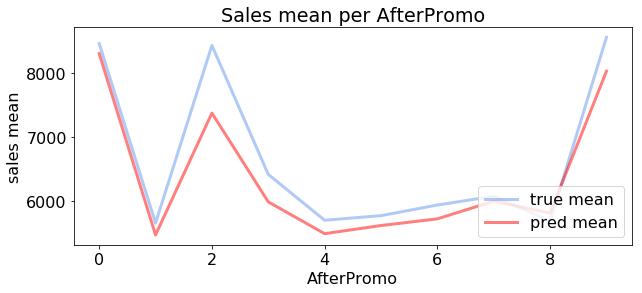

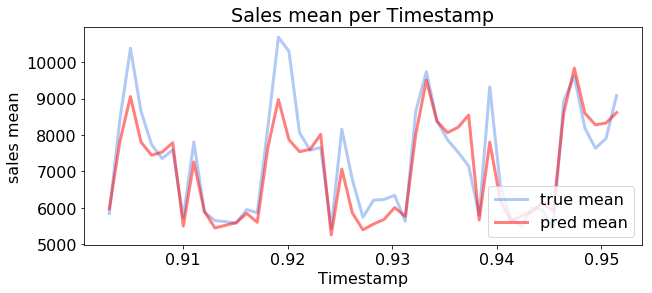

In [37]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

display_cols = formated_df.select_dtypes(include=numerics).columns
display_cols =  list(set( list(display_cols)))

for col in display_cols:
    compare_result_plot(results, col)
    #compare_result_plot(test_set.loc[X_test.index, [col_new_name]], pd.DataFrame(y_true), pd.DataFrame(y_pred), col_new_name)